Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [8]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [9]:
# deJPEG 
fname = 'data/denoising/snail.jpg'

## denoising
# fname = 'data/denoising/F16_GT.png'

# Load image

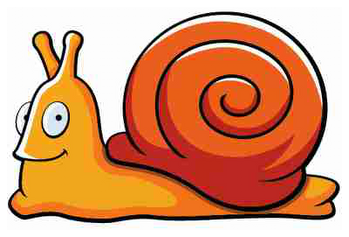

In [10]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [11]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    num_iter = 1500
    input_depth = 32 
    figsize = 4 
    
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 572827


In [12]:
def _init_dcvx_parameters(net_to_dcvx):
    # parameters = [p for p in self.image_net.named_parameters()] + \
    #              [p for p in self.mask_net.named_parameters()]
    #     net_to_dcvx = [self.left_net,self.right_net]
    # if self._is_learning_ambient():
    #     net_to_dcvx.append(self.ambient_net)

    # set_trace()
    parameters = list()
    for net in net_to_dcvx:
        # for name, p  in net.named_parameters():
        #     print(name, end=' ')
        layer_id = 0
        # set_trace()
        for name, p  in net.named_parameters():
            layer_id +=1
            if "weight" in name and layer_id>7 and p.dim()>1:
                parameters.append(p)
                print(name)
    return parameters

def dcvx(parameters):
    neg_weight_reg  = 0.0 
    #parameters =self.dcvx_parameters
    for p in parameters:
        neg_weight_reg += torch.norm(p[p<0])
    return neg_weight_reg

dcvx_ = 1
dcvx_coeff= 0.000005
# if 'lib' in img_path:
#     dcvx_coeff= 0.00002
parameters = _init_dcvx_parameters([net])
stop_dcvx = 0

1.7.1.1.1.weight
1.7.1.4.1.weight
1.7.1.7.1.1.1.weight
1.7.1.7.1.4.1.weight
1.7.1.7.1.7.1.0.1.1.weight
1.7.1.7.1.7.1.1.1.1.weight
1.7.1.7.1.7.1.1.4.1.weight
1.7.1.7.1.7.1.1.7.1.0.1.1.weight
1.7.1.7.1.7.1.1.7.1.1.1.1.weight
1.7.1.7.1.7.1.1.7.1.1.4.1.weight
1.7.1.7.1.7.1.1.7.3.1.weight
1.7.1.7.1.7.1.1.7.6.1.weight
1.7.1.7.1.7.3.1.weight
1.7.1.7.1.7.6.1.weight
1.7.1.7.3.1.weight
1.7.1.7.6.1.weight
1.7.3.1.weight
1.7.6.1.weight
3.1.weight
6.1.weight
9.1.weight


# Optimize

Starting optimization with ADAM
dcvx_loss:tensor(0.0003) total_loss:tensor(0.1523)


c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:37: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:38: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:39: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


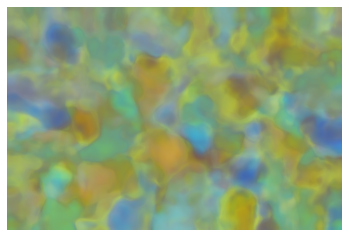

dcvx_loss:tensor(0.0006) total_loss:tensor(0.0636)721730   PSRN_gt: 11.721730 PSNR_gt_sm: 9.702294 
dcvx_loss:tensor(0.0006) total_loss:tensor(0.0428)530709   PSRN_gt: 13.530709 PSNR_gt_sm: 11.518308 


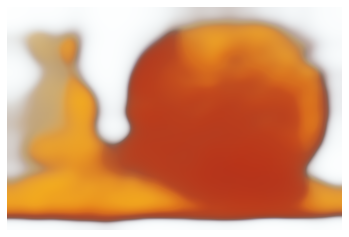

dcvx_loss:tensor(0.0006) total_loss:tensor(0.0339)701519   PSRN_gt: 14.701519 PSNR_gt_sm: 13.020403 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0321)024114   PSRN_gt: 15.024114 PSNR_gt_sm: 14.187303 


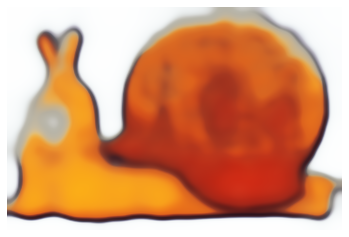

Falling back to previous checkpoint.SNR_noisy: 15.431830   PSRN_gt: 15.431830 PSNR_gt_sm: 15.100424 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0253)521746   PSRN_gt: 15.521746 PSNR_gt_sm: 15.197474 
Falling back to previous checkpoint.SNR_noisy: 15.959522   PSRN_gt: 15.959522 PSNR_gt_sm: 15.487890 
Falling back to previous checkpoint.SNR_noisy: 15.728319   PSRN_gt: 15.728319 PSNR_gt_sm: 15.572930 
Falling back to previous checkpoint.SNR_noisy: 15.674273   PSRN_gt: 15.674273 PSNR_gt_sm: 15.630617 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0197)584554   PSRN_gt: 16.584554 PSNR_gt_sm: 16.233351 


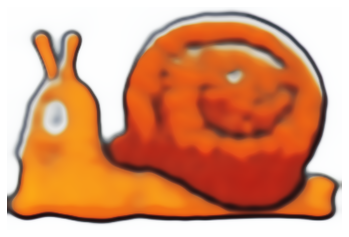

Falling back to previous checkpoint.SNR_noisy: 16.320426   PSRN_gt: 16.320426 PSNR_gt_sm: 16.652607 
Falling back to previous checkpoint.SNR_noisy: 17.215541   PSRN_gt: 17.215541 PSNR_gt_sm: 16.992119 
Falling back to previous checkpoint.SNR_noisy: 16.800122   PSRN_gt: 16.800122 PSNR_gt_sm: 17.109130 
Falling back to previous checkpoint.SNR_noisy: 16.417894   PSRN_gt: 16.417894 PSNR_gt_sm: 17.218840 
dcvx_loss:tensor(0.0007) total_loss:tensor(0.0146)229788   PSRN_gt: 18.229788 PSNR_gt_sm: 17.260608 
Falling back to previous checkpoint.SNR_noisy: 17.770595   PSRN_gt: 17.770595 PSNR_gt_sm: 17.304723 
Falling back to previous checkpoint.SNR_noisy: 18.022822   PSRN_gt: 18.022822 PSNR_gt_sm: 17.349444 
Falling back to previous checkpoint.SNR_noisy: 17.714639   PSRN_gt: 17.714639 PSNR_gt_sm: 17.580745 
Falling back to previous checkpoint.SNR_noisy: 18.110720   PSRN_gt: 18.110720 PSNR_gt_sm: 17.846486 
Falling back to previous checkpoint.SNR_noisy: 18.364993   PSRN_gt: 18.364993 PSNR_gt_sm: 1

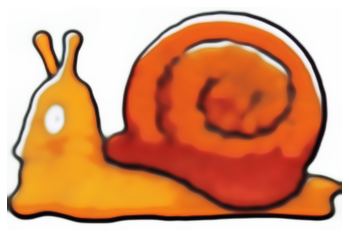

Falling back to previous checkpoint.SNR_noisy: 18.558210   PSRN_gt: 18.558210 PSNR_gt_sm: 18.829991 
Falling back to previous checkpoint.SNR_noisy: 18.464381   PSRN_gt: 18.464381 PSNR_gt_sm: 18.883595 
Falling back to previous checkpoint.SNR_noisy: 18.871493   PSRN_gt: 18.871493 PSNR_gt_sm: 18.942188 
Falling back to previous checkpoint.SNR_noisy: 19.406924   PSRN_gt: 19.406924 PSNR_gt_sm: 19.086450 
Falling back to previous checkpoint.SNR_noisy: 19.089958   PSRN_gt: 19.089958 PSNR_gt_sm: 19.124771 
Falling back to previous checkpoint.SNR_noisy: 19.096122   PSRN_gt: 19.096122 PSNR_gt_sm: 19.222541 
Falling back to previous checkpoint.SNR_noisy: 19.534823   PSRN_gt: 19.534823 PSNR_gt_sm: 19.429048 
dcvx_loss:tensor(0.0008) total_loss:tensor(0.0107)607670   PSRN_gt: 19.607670 PSNR_gt_sm: 19.524733 
Falling back to previous checkpoint.SNR_noisy: 18.716692   PSRN_gt: 18.716692 PSNR_gt_sm: 19.573414 
Falling back to previous checkpoint.SNR_noisy: 19.378426   PSRN_gt: 19.378426 PSNR_gt_sm: 1

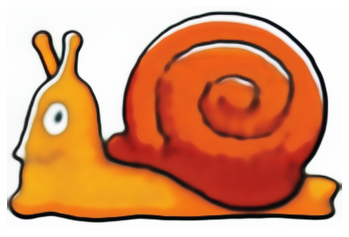

Falling back to previous checkpoint.SNR_noisy: 19.920879   PSRN_gt: 19.920879 PSNR_gt_sm: 20.509148 
Falling back to previous checkpoint.SNR_noisy: 19.498832   PSRN_gt: 19.498832 PSNR_gt_sm: 20.520767 
Falling back to previous checkpoint.SNR_noisy: 19.640592   PSRN_gt: 19.640592 PSNR_gt_sm: 20.707379 
Falling back to previous checkpoint.SNR_noisy: 19.957206   PSRN_gt: 19.957206 PSNR_gt_sm: 20.849365 
Falling back to previous checkpoint.SNR_noisy: 20.559381   PSRN_gt: 20.559381 PSNR_gt_sm: 21.012183 
Falling back to previous checkpoint.SNR_noisy: 20.615169   PSRN_gt: 20.615169 PSNR_gt_sm: 21.073335 
Falling back to previous checkpoint.SNR_noisy: 20.335615   PSRN_gt: 20.335615 PSNR_gt_sm: 21.164334 
Falling back to previous checkpoint.SNR_noisy: 20.831524   PSRN_gt: 20.831524 PSNR_gt_sm: 21.210538 
dcvx_loss:tensor(0.0008) total_loss:tensor(0.0072)034977   PSRN_gt: 21.034977 PSNR_gt_sm: 21.306253 
Falling back to previous checkpoint.SNR_noisy: 20.901271   PSRN_gt: 20.901271 PSNR_gt_sm: 2

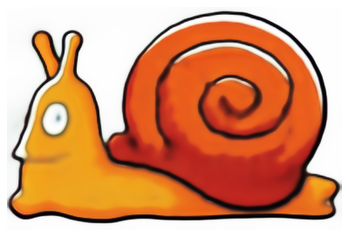

Falling back to previous checkpoint.SNR_noisy: 20.600979   PSRN_gt: 20.600979 PSNR_gt_sm: 22.157092 
Falling back to previous checkpoint.SNR_noisy: 21.647075   PSRN_gt: 21.647075 PSNR_gt_sm: 22.245973 
Falling back to previous checkpoint.SNR_noisy: 21.287654   PSRN_gt: 21.287654 PSNR_gt_sm: 22.284832 
Falling back to previous checkpoint.SNR_noisy: 21.345073   PSRN_gt: 21.345073 PSNR_gt_sm: 22.296522 
Falling back to previous checkpoint.SNR_noisy: 21.162126   PSRN_gt: 21.162126 PSNR_gt_sm: 22.306591 
Falling back to previous checkpoint.SNR_noisy: 21.422207   PSRN_gt: 21.422207 PSNR_gt_sm: 22.318895 
Falling back to previous checkpoint.SNR_noisy: 20.756587   PSRN_gt: 20.756587 PSNR_gt_sm: 22.326668 
Falling back to previous checkpoint.SNR_noisy: 20.616212   PSRN_gt: 20.616212 PSNR_gt_sm: 22.336047 
Falling back to previous checkpoint.SNR_noisy: 20.551522   PSRN_gt: 20.551522 PSNR_gt_sm: 22.343401 
Falling back to previous checkpoint.SNR_noisy: 21.227989   PSRN_gt: 21.227989 PSNR_gt_sm: 2

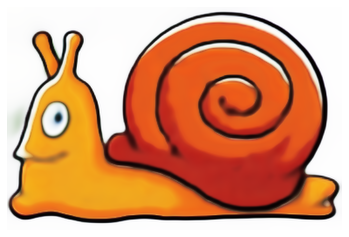

Falling back to previous checkpoint.SNR_noisy: 22.101413   PSRN_gt: 22.101413 PSNR_gt_sm: 23.467818 
Falling back to previous checkpoint.SNR_noisy: 22.041204   PSRN_gt: 22.041204 PSNR_gt_sm: 23.528165 
Falling back to previous checkpoint.SNR_noisy: 22.227808   PSRN_gt: 22.227808 PSNR_gt_sm: 23.694658 
Falling back to previous checkpoint.SNR_noisy: 22.308239   PSRN_gt: 22.308239 PSNR_gt_sm: 23.739091 
Falling back to previous checkpoint.SNR_noisy: 22.710941   PSRN_gt: 22.710941 PSNR_gt_sm: 23.758280 
Falling back to previous checkpoint.SNR_noisy: 22.944881   PSRN_gt: 22.944881 PSNR_gt_sm: 23.766811 
Falling back to previous checkpoint.SNR_noisy: 22.453072   PSRN_gt: 22.453072 PSNR_gt_sm: 23.773978 
Falling back to previous checkpoint.SNR_noisy: 22.323026   PSRN_gt: 22.323026 PSNR_gt_sm: 23.781108 
Falling back to previous checkpoint.SNR_noisy: 21.636151   PSRN_gt: 21.636151 PSNR_gt_sm: 23.786589 
Falling back to previous checkpoint.SNR_noisy: 21.404137   PSRN_gt: 21.404137 PSNR_gt_sm: 2

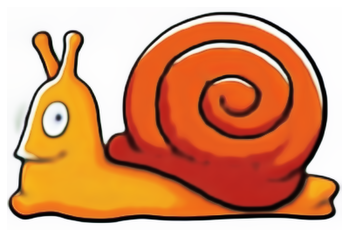

Falling back to previous checkpoint.SNR_noisy: 22.845463   PSRN_gt: 22.845463 PSNR_gt_sm: 24.450117 
Falling back to previous checkpoint.SNR_noisy: 23.102755   PSRN_gt: 23.102755 PSNR_gt_sm: 24.483074 
Falling back to previous checkpoint.SNR_noisy: 22.620356   PSRN_gt: 22.620356 PSNR_gt_sm: 24.624868 
Falling back to previous checkpoint.SNR_noisy: 22.750097   PSRN_gt: 22.750097 PSNR_gt_sm: 24.650291 
Falling back to previous checkpoint.SNR_noisy: 22.521071   PSRN_gt: 22.521071 PSNR_gt_sm: 24.652290 
Falling back to previous checkpoint.SNR_noisy: 22.484945   PSRN_gt: 22.484945 PSNR_gt_sm: 24.661230 
Falling back to previous checkpoint.SNR_noisy: 23.126800   PSRN_gt: 23.126800 PSNR_gt_sm: 24.665063 
Falling back to previous checkpoint.SNR_noisy: 22.957613   PSRN_gt: 22.957613 PSNR_gt_sm: 24.667812 
Falling back to previous checkpoint.SNR_noisy: 22.771995   PSRN_gt: 22.771995 PSNR_gt_sm: 24.670826 
Falling back to previous checkpoint.SNR_noisy: 22.827845   PSRN_gt: 22.827845 PSNR_gt_sm: 2

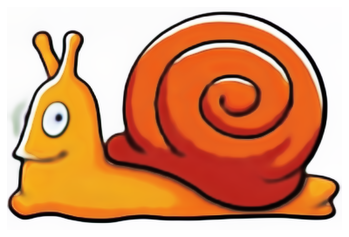

Falling back to previous checkpoint.SNR_noisy: 23.311405   PSRN_gt: 23.311405 PSNR_gt_sm: 25.072403 
Falling back to previous checkpoint.SNR_noisy: 23.559562   PSRN_gt: 23.559562 PSNR_gt_sm: 25.076109 
Falling back to previous checkpoint.SNR_noisy: 23.455332   PSRN_gt: 23.455332 PSNR_gt_sm: 25.079642 
Falling back to previous checkpoint.SNR_noisy: 23.757630   PSRN_gt: 23.757630 PSNR_gt_sm: 25.083632 
Falling back to previous checkpoint.SNR_noisy: 23.750317   PSRN_gt: 23.750317 PSNR_gt_sm: 25.098070 
Falling back to previous checkpoint.SNR_noisy: 23.632779   PSRN_gt: 23.632779 PSNR_gt_sm: 25.121933 
Falling back to previous checkpoint.SNR_noisy: 23.743438   PSRN_gt: 23.743438 PSNR_gt_sm: 25.126506 
Falling back to previous checkpoint.SNR_noisy: 23.869469   PSRN_gt: 23.869469 PSNR_gt_sm: 25.140974 
Falling back to previous checkpoint.SNR_noisy: 23.985145   PSRN_gt: 23.985145 PSNR_gt_sm: 25.145775 
Falling back to previous checkpoint.SNR_noisy: 24.023955   PSRN_gt: 24.023955 PSNR_gt_sm: 2

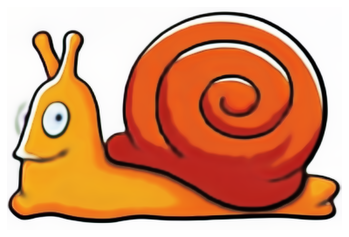

Falling back to previous checkpoint.SNR_noisy: 23.750304   PSRN_gt: 23.750304 PSNR_gt_sm: 25.500248 
Falling back to previous checkpoint.SNR_noisy: 24.070270   PSRN_gt: 24.070270 PSNR_gt_sm: 25.597203 
Falling back to previous checkpoint.SNR_noisy: 24.106173   PSRN_gt: 24.106173 PSNR_gt_sm: 25.607225 
Falling back to previous checkpoint.SNR_noisy: 24.138264   PSRN_gt: 24.138264 PSNR_gt_sm: 25.609308 
Falling back to previous checkpoint.SNR_noisy: 24.106255   PSRN_gt: 24.106255 PSNR_gt_sm: 25.611900 
Falling back to previous checkpoint.SNR_noisy: 23.871198   PSRN_gt: 23.871198 PSNR_gt_sm: 25.613906 
Falling back to previous checkpoint.SNR_noisy: 23.595409   PSRN_gt: 23.595409 PSNR_gt_sm: 25.615942 
Falling back to previous checkpoint.SNR_noisy: 23.166713   PSRN_gt: 23.166713 PSNR_gt_sm: 25.616724 
Falling back to previous checkpoint.SNR_noisy: 22.916476   PSRN_gt: 22.916476 PSNR_gt_sm: 25.617565 
Falling back to previous checkpoint.SNR_noisy: 22.842799   PSRN_gt: 22.842799 PSNR_gt_sm: 2

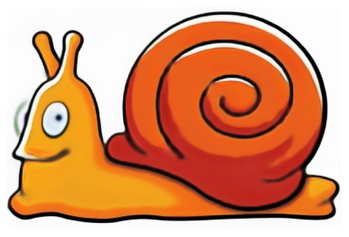

Falling back to previous checkpoint.SNR_noisy: 23.877374   PSRN_gt: 23.877374 PSNR_gt_sm: 25.850824 
Falling back to previous checkpoint.SNR_noisy: 24.105653   PSRN_gt: 24.105653 PSNR_gt_sm: 25.874486 
Falling back to previous checkpoint.SNR_noisy: 24.576432   PSRN_gt: 24.576432 PSNR_gt_sm: 25.928336 
Falling back to previous checkpoint.SNR_noisy: 24.356165   PSRN_gt: 24.356165 PSNR_gt_sm: 25.945159 
Falling back to previous checkpoint.SNR_noisy: 24.521441   PSRN_gt: 24.521441 PSNR_gt_sm: 25.949050 
Falling back to previous checkpoint.SNR_noisy: 24.404134   PSRN_gt: 24.404134 PSNR_gt_sm: 25.950753 
Falling back to previous checkpoint.SNR_noisy: 24.407669   PSRN_gt: 24.407669 PSNR_gt_sm: 25.954207 
Falling back to previous checkpoint.SNR_noisy: 24.421627   PSRN_gt: 24.421627 PSNR_gt_sm: 25.956164 
Falling back to previous checkpoint.SNR_noisy: 24.261642   PSRN_gt: 24.261642 PSNR_gt_sm: 25.959386 
Falling back to previous checkpoint.SNR_noisy: 23.653539   PSRN_gt: 23.653539 PSNR_gt_sm: 2

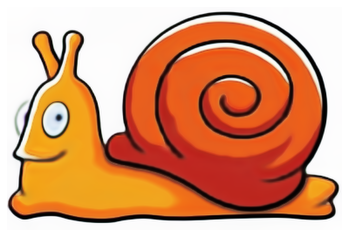

Falling back to previous checkpoint.SNR_noisy: 24.871670   PSRN_gt: 24.871670 PSNR_gt_sm: 26.238265 
Falling back to previous checkpoint.SNR_noisy: 24.725324   PSRN_gt: 24.725324 PSNR_gt_sm: 26.246378 
Falling back to previous checkpoint.SNR_noisy: 24.779502   PSRN_gt: 24.779502 PSNR_gt_sm: 26.248438 
Falling back to previous checkpoint.SNR_noisy: 24.806185   PSRN_gt: 24.806185 PSNR_gt_sm: 26.250423 
Falling back to previous checkpoint.SNR_noisy: 24.787782   PSRN_gt: 24.787782 PSNR_gt_sm: 26.258943 
Falling back to previous checkpoint.SNR_noisy: 24.902177   PSRN_gt: 24.902177 PSNR_gt_sm: 26.266889 
Falling back to previous checkpoint.SNR_noisy: 24.904518   PSRN_gt: 24.904518 PSNR_gt_sm: 26.267657 
Falling back to previous checkpoint.SNR_noisy: 24.898228   PSRN_gt: 24.898228 PSNR_gt_sm: 26.269836 
Falling back to previous checkpoint.SNR_noisy: 24.662593   PSRN_gt: 24.662593 PSNR_gt_sm: 26.270755 
Falling back to previous checkpoint.SNR_noisy: 24.609947   PSRN_gt: 24.609947 PSNR_gt_sm: 2

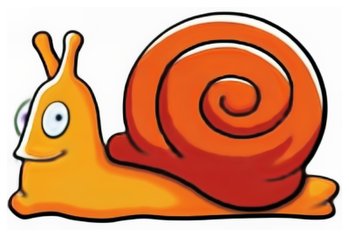

Falling back to previous checkpoint.SNR_noisy: 25.297327   PSRN_gt: 25.297327 PSNR_gt_sm: 26.565129 
Falling back to previous checkpoint.SNR_noisy: 25.263624   PSRN_gt: 25.263624 PSNR_gt_sm: 26.573021 
Falling back to previous checkpoint.SNR_noisy: 25.301920   PSRN_gt: 25.301920 PSNR_gt_sm: 26.575908 
Falling back to previous checkpoint.SNR_noisy: 24.830644   PSRN_gt: 24.830644 PSNR_gt_sm: 26.576517 
Falling back to previous checkpoint.SNR_noisy: 24.415070   PSRN_gt: 24.415070 PSNR_gt_sm: 26.578523 
Falling back to previous checkpoint.SNR_noisy: 23.790252   PSRN_gt: 23.790252 PSNR_gt_sm: 26.577442 
Falling back to previous checkpoint.SNR_noisy: 23.796436   PSRN_gt: 23.796436 PSNR_gt_sm: 26.578625 
Falling back to previous checkpoint.SNR_noisy: 23.128535   PSRN_gt: 23.128535 PSNR_gt_sm: 26.576975 
Falling back to previous checkpoint.SNR_noisy: 22.665659   PSRN_gt: 22.665659 PSNR_gt_sm: 26.576372 
Falling back to previous checkpoint.SNR_noisy: 21.965551   PSRN_gt: 21.965551 PSNR_gt_sm: 2

Falling back to previous checkpoint.SNR_noisy: 24.691825   PSRN_gt: 24.691825 PSNR_gt_sm: 26.559370 
Falling back to previous checkpoint.SNR_noisy: 24.715031   PSRN_gt: 24.715031 PSNR_gt_sm: 26.559384 
Falling back to previous checkpoint.SNR_noisy: 24.578436   PSRN_gt: 24.578436 PSNR_gt_sm: 26.560483 
Falling back to previous checkpoint.SNR_noisy: 24.395944   PSRN_gt: 24.395944 PSNR_gt_sm: 26.559703 
Falling back to previous checkpoint.SNR_noisy: 24.470036   PSRN_gt: 24.470036 PSNR_gt_sm: 26.560525 
Falling back to previous checkpoint.SNR_noisy: 24.329478   PSRN_gt: 24.329478 PSNR_gt_sm: 26.559763 
Falling back to previous checkpoint.SNR_noisy: 24.481945   PSRN_gt: 24.481945 PSNR_gt_sm: 26.560813 
Falling back to previous checkpoint.SNR_noisy: 23.992910   PSRN_gt: 23.992910 PSNR_gt_sm: 26.559808 
Falling back to previous checkpoint.SNR_noisy: 23.899115   PSRN_gt: 23.899115 PSNR_gt_sm: 26.559268 
Falling back to previous checkpoint.SNR_noisy: 23.710185   PSRN_gt: 23.710185 PSNR_gt_sm: 2

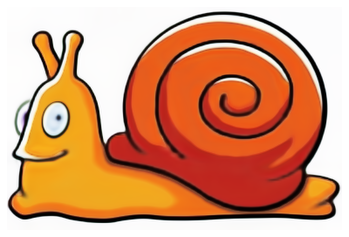

dcvx_loss:tensor(0.0008) total_loss:tensor(0.0025)075029   PSRN_gt: 26.075029 PSNR_gt_sm: 26.869479 
Falling back to previous checkpoint.SNR_noisy: 25.245623   PSRN_gt: 25.245623 PSNR_gt_sm: 26.920150 
Falling back to previous checkpoint.SNR_noisy: 24.775527   PSRN_gt: 24.775527 PSNR_gt_sm: 26.924444 
Falling back to previous checkpoint.SNR_noisy: 24.409730   PSRN_gt: 24.409730 PSNR_gt_sm: 26.925048 
Falling back to previous checkpoint.SNR_noisy: 23.889084   PSRN_gt: 23.889084 PSNR_gt_sm: 26.923224 
Falling back to previous checkpoint.SNR_noisy: 23.568727   PSRN_gt: 23.568727 PSNR_gt_sm: 26.922365 
Falling back to previous checkpoint.SNR_noisy: 23.190466   PSRN_gt: 23.190466 PSNR_gt_sm: 26.919229 
Falling back to previous checkpoint.SNR_noisy: 23.071719   PSRN_gt: 23.071719 PSNR_gt_sm: 26.917756 
Falling back to previous checkpoint.SNR_noisy: 22.642849   PSRN_gt: 22.642849 PSNR_gt_sm: 26.914283 
Falling back to previous checkpoint.SNR_noisy: 22.160244   PSRN_gt: 22.160244 PSNR_gt_sm: 2

Falling back to previous checkpoint.SNR_noisy: 24.315866   PSRN_gt: 24.315866 PSNR_gt_sm: 26.754452 
Falling back to previous checkpoint.SNR_noisy: 24.228666   PSRN_gt: 24.228666 PSNR_gt_sm: 26.756328 
Falling back to previous checkpoint.SNR_noisy: 23.671411   PSRN_gt: 23.671411 PSNR_gt_sm: 26.754731 
Falling back to previous checkpoint.SNR_noisy: 23.387942   PSRN_gt: 23.387942 PSNR_gt_sm: 26.754294 
Falling back to previous checkpoint.SNR_noisy: 23.451011   PSRN_gt: 23.451011 PSNR_gt_sm: 26.752711 
Falling back to previous checkpoint.SNR_noisy: 23.280692   PSRN_gt: 23.280692 PSNR_gt_sm: 26.752882 
Falling back to previous checkpoint.SNR_noisy: 23.197478   PSRN_gt: 23.197478 PSNR_gt_sm: 26.751273 
Falling back to previous checkpoint.SNR_noisy: 23.258659   PSRN_gt: 23.258659 PSNR_gt_sm: 26.750727 
Falling back to previous checkpoint.SNR_noisy: 23.348442   PSRN_gt: 23.348442 PSNR_gt_sm: 26.749480 
Falling back to previous checkpoint.SNR_noisy: 23.315399   PSRN_gt: 23.315399 PSNR_gt_sm: 2

Falling back to previous checkpoint.SNR_noisy: 24.968087   PSRN_gt: 24.968087 PSNR_gt_sm: 26.810973 
Falling back to previous checkpoint.SNR_noisy: 24.917330   PSRN_gt: 24.917330 PSNR_gt_sm: 26.811381 
Falling back to previous checkpoint.SNR_noisy: 24.822312   PSRN_gt: 24.822312 PSNR_gt_sm: 26.810994 
Falling back to previous checkpoint.SNR_noisy: 25.063208   PSRN_gt: 25.063208 PSNR_gt_sm: 26.812058 
Falling back to previous checkpoint.SNR_noisy: 25.018812   PSRN_gt: 25.018812 PSNR_gt_sm: 26.812290 
Falling back to previous checkpoint.SNR_noisy: 24.916366   PSRN_gt: 24.916366 PSNR_gt_sm: 26.812681 
Falling back to previous checkpoint.SNR_noisy: 24.475455   PSRN_gt: 24.475455 PSNR_gt_sm: 26.811304 
Falling back to previous checkpoint.SNR_noisy: 24.592938   PSRN_gt: 24.592938 PSNR_gt_sm: 26.810495 
Falling back to previous checkpoint.SNR_noisy: 24.428185   PSRN_gt: 24.428185 PSNR_gt_sm: 26.808885 
Falling back to previous checkpoint.SNR_noisy: 24.527385   PSRN_gt: 24.527385 PSNR_gt_sm: 2

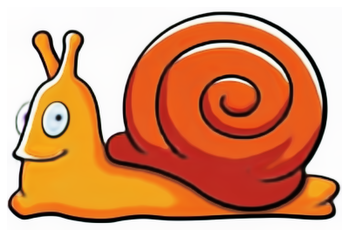

dcvx_loss:tensor(0.0008) total_loss:tensor(0.0024)878762   PSRN_gt: 25.878762 PSNR_gt_sm: 27.023802 
Falling back to previous checkpoint.SNR_noisy: 25.814148   PSRN_gt: 25.814148 PSNR_gt_sm: 27.085438 
Falling back to previous checkpoint.SNR_noisy: 25.754285   PSRN_gt: 25.754285 PSNR_gt_sm: 27.129836 
dcvx_loss:tensor(0.0008) total_loss:tensor(0.0024)315240   PSRN_gt: 26.315240 PSNR_gt_sm: 27.133661 


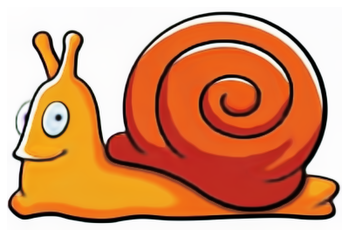

Falling back to previous checkpoint.SNR_noisy: 25.603322   PSRN_gt: 25.603322 PSNR_gt_sm: 27.145524 
Falling back to previous checkpoint.SNR_noisy: 25.614804   PSRN_gt: 25.614804 PSNR_gt_sm: 27.199439 
Falling back to previous checkpoint.SNR_noisy: 25.433537   PSRN_gt: 25.433537 PSNR_gt_sm: 27.202087 
Falling back to previous checkpoint.SNR_noisy: 25.241985   PSRN_gt: 25.241985 PSNR_gt_sm: 27.202411 
Falling back to previous checkpoint.SNR_noisy: 25.159517   PSRN_gt: 25.159517 PSNR_gt_sm: 27.203025 
Falling back to previous checkpoint.SNR_noisy: 25.032855   PSRN_gt: 25.032855 PSNR_gt_sm: 27.202724 
Falling back to previous checkpoint.SNR_noisy: 24.845221   PSRN_gt: 24.845221 PSNR_gt_sm: 27.203663 
Falling back to previous checkpoint.SNR_noisy: 22.936904   PSRN_gt: 22.936904 PSNR_gt_sm: 27.200681 
Falling back to previous checkpoint.SNR_noisy: 23.539237   PSRN_gt: 23.539237 PSNR_gt_sm: 27.199618 
Falling back to previous checkpoint.SNR_noisy: 23.682819   PSRN_gt: 23.682819 PSNR_gt_sm: 2

Falling back to previous checkpoint.SNR_noisy: 25.124319   PSRN_gt: 25.124319 PSNR_gt_sm: 27.064934 
Falling back to previous checkpoint.SNR_noisy: 25.189372   PSRN_gt: 25.189372 PSNR_gt_sm: 27.067062 
Falling back to previous checkpoint.SNR_noisy: 24.933603   PSRN_gt: 24.933603 PSNR_gt_sm: 27.066589 
Falling back to previous checkpoint.SNR_noisy: 25.198990   PSRN_gt: 25.198990 PSNR_gt_sm: 27.068591 
Falling back to previous checkpoint.SNR_noisy: 25.032967   PSRN_gt: 25.032967 PSNR_gt_sm: 27.068448 
Falling back to previous checkpoint.SNR_noisy: 25.310408   PSRN_gt: 25.310408 PSNR_gt_sm: 27.070702 
Falling back to previous checkpoint.SNR_noisy: 25.181179   PSRN_gt: 25.181179 PSNR_gt_sm: 27.070785 
Falling back to previous checkpoint.SNR_noisy: 25.338960   PSRN_gt: 25.338960 PSNR_gt_sm: 27.072757 
Falling back to previous checkpoint.SNR_noisy: 25.235193   PSRN_gt: 25.235193 PSNR_gt_sm: 27.072633 
Falling back to previous checkpoint.SNR_noisy: 25.298018   PSRN_gt: 25.298018 PSNR_gt_sm: 2

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [13]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0

def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input,dcvx_,stop_dcvx, dcvx_coeff
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    if dcvx_ and not stop_dcvx:
        dcvx_loss = dcvx(parameters)*dcvx_coeff
        if i%50==0:
            print("dcvx_loss:"+str(dcvx_loss.data.cpu())+ " total_loss:"+str(total_loss.data.cpu()))
        if dcvx_loss.data.cpu()> (total_loss.data.cpu()*2):
            dcvx_coeff = dcvx_coeff*0.25
            #stop_dcvx = 1
        total_loss += dcvx_loss
            
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        #plot_image_grid([np.clip(out_np, 0, 1), np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -0.5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [1]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

NameError: name 'torch_to_np' is not defined